In [1]:
import torch
import sys
import os
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath("../..")) 
from datetime import datetime

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

from dataloader.dataloader import load_MNIST_data,load_CINIC10_data,load_CIFAR10_data,load_Fmnist_data,load_Covtype_data
from train.training import train_nomal,train_for_DEQ
from train.evaluate import plot_loss_curve,plot_errorbar_losscurve,plot_confusion_matrix,plot_histograms,create_table,convergence_verify
from result_management.data_manager import save_csv,auto_git_push,save_experiment_report,create_result_pdf
now = datetime.now()
formatted_time = now.strftime("%m%d%H%M")
formatted_time = int(formatted_time)
print(f'-----Formatted time: {formatted_time} -----')

Using device: cpu
-----Formatted time: 8201700 -----


----------------------Running with none: 0----------------------


1/5th Epoch:20/20(100.00%) 

Test Accuracy:45.33


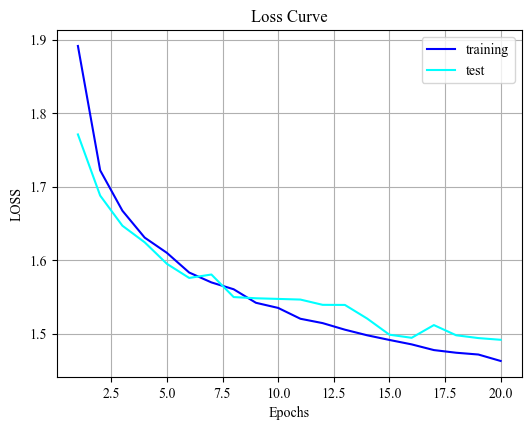

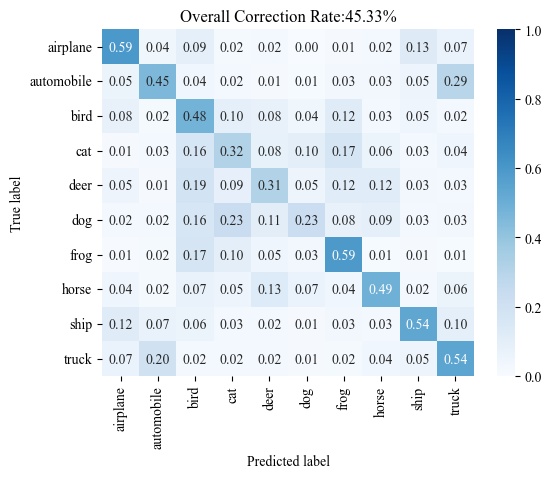

2/5th Epoch:20/20(100.00%) 

Test Accuracy:44.82


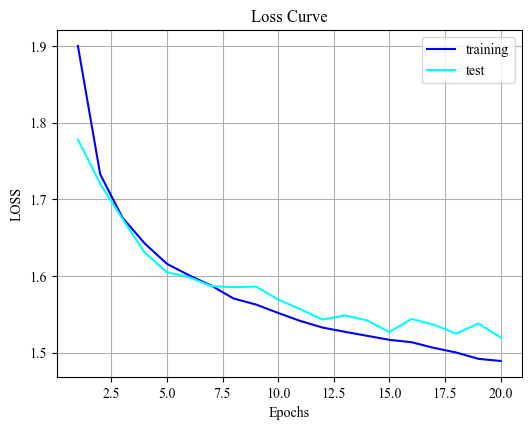

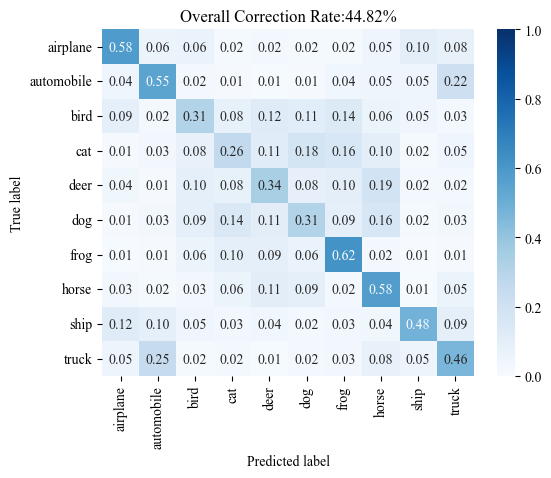

3/5th Epoch:20/20(100.00%) 

Test Accuracy:44.50


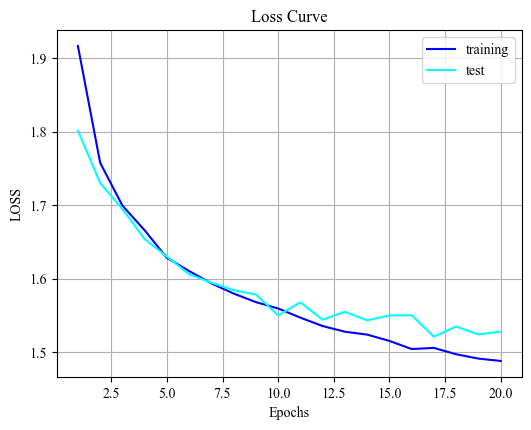

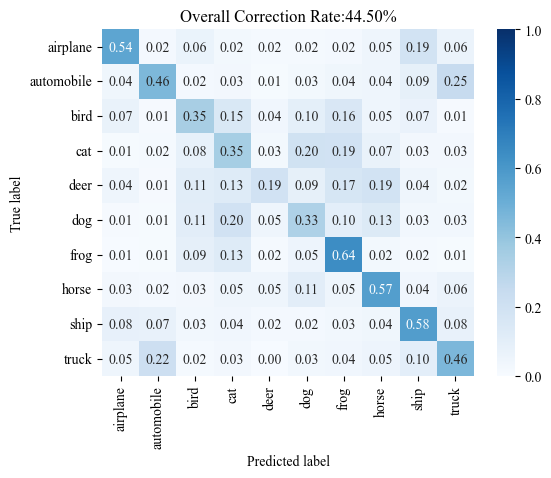

4/5th Epoch:20/20(100.00%) 

Test Accuracy:44.91


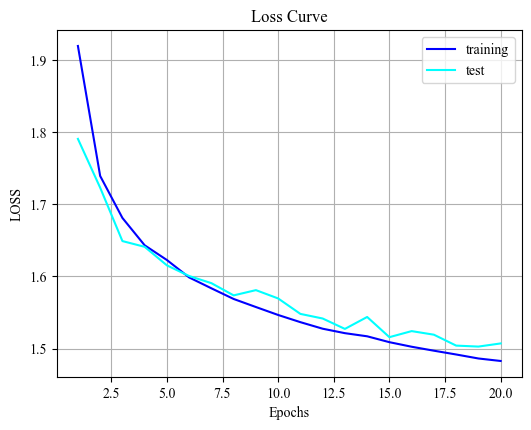

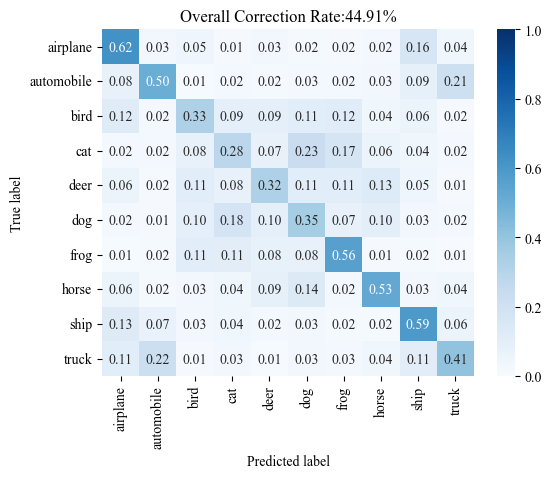

5/5th Epoch:20/20(100.00%) 

Test Accuracy:45.28


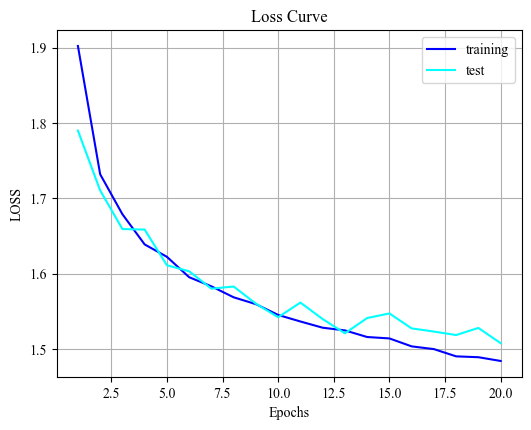

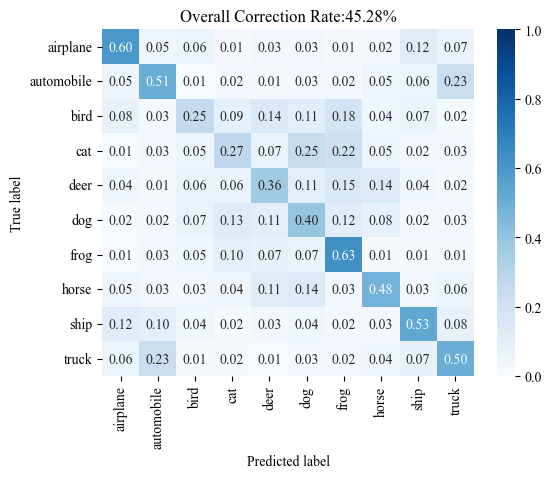

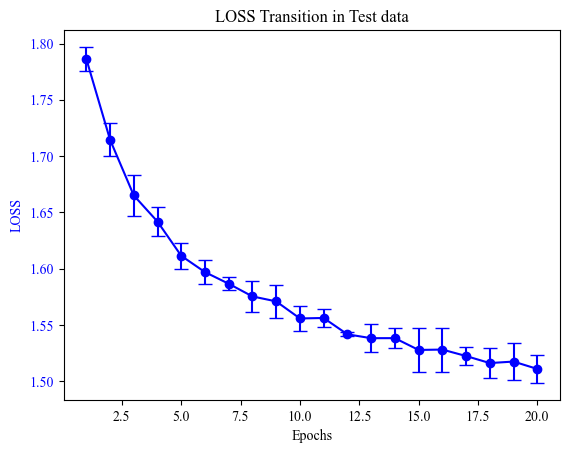

         Average  Best ID     Best  Worst ID    Worst
0   ACC   44.968        1   45.330         3   44.500
1  LOSS    1.511        1    1.491         3    1.528
2  TIME  741.311        2  678.131         1  809.566
Loading CSV file: /Users/konishi/Library/CloudStorage/OneDrive-個人用(2)/PhotonicEncoder_data/cinic-10/none_variable/PM/CNN/Normal8201700/0none_1th_.csv
Error loading CSV file 0none_1th_.csv: [Errno 2] No such file or directory: '/Users/konishi/Library/CloudStorage/OneDrive-個人用(2)/PhotonicEncoder_data/cinic-10/none_variable/PM/CNN/Normal8201700/0none_1th_.csv'


ValueError: not enough values to unpack (expected 5, got 0)

In [3]:
experiment_type = "Normal"
experiment_name = f"{experiment_type}{formatted_time}"
variable_param = "none" #ここで設定した項目は配列にすること(none,leverage,alpha)
save = False
Show =True

params = {
    'none':[0], #variable_param=noneの際は1回だけ繰り返す
    #data---------------------------------------------
    'dataset': 'cinic-10', # 'mnist', 'cifar-10', 'cinic-10' , 'fashion-mnist'
    'batch_size': 100, #64 MNIST, 100 CIFAR10, 100 CINIC10

    #Encoder_Model--------------------------------
    'enc_type': 'PM', # 'none', 'MZM', 'LI'
    'alpha': np.pi/2, 
    #位相変調機の感度[np.pi*2,np.pi, np.pi/2, np.pi/4, np.pi/8, np.pi/16],pi:-π~π
    #class_model--------------------------------------
    'cls_type': 'CNN', # 'MLP' or 'CNN'
    'num_layer': 2,
    'fc': 'relu',
    'dropout': 0.0,

    #learning-----------------------------------------
    'loss_func': 'cross_entropy',
    'optimizer': 'adam',
    'lr': 0.001,

    #param--------------------------------------------
    'num_try': 5,
    'max_epochs': 20,
    'leverage': 8, #mnist:[1,2,4,8,16],cinic:[1,2,3,4,6,8,12,16,24,48] enc is not none
    'kernel_size': 4
}
#save---------------------------------------------
folder_params = {k: params[k] for k in ['dataset', 'enc_type', 'cls_type']}
if save:
    save_experiment_report(variable_param, params,experiment_name=experiment_name)

data_loaders = {
    'cifar-10': load_CIFAR10_data,
    'cinic-10': load_CINIC10_data,
    'mnist': load_MNIST_data,
    'fashion-mnist':load_Fmnist_data,
    'covtype': load_Covtype_data
}

data_train,data_test = data_loaders[params["dataset"]]()
if params["enc_type"] == 'none':
    leverage = 1
results = []
All_last_LOSSs_ = []
All_last_ACCs_ = []
All_TIMEs_ = []

for variable in params[variable_param]: #variable:leverage,alpha
    print(f'----------------------Running with {variable_param}: {variable}----------------------')
    All_last_loss = []
    All_loss_test = []
    All_pro_time = []
    All_test_acc = []

    for num_times in range(params['num_try']):
        params_for_train = {k: v for k,v in params.items() if k not in ('none',variable_param)}#配列を除外

        if variable_param != 'none': #leverageやalpha可変のとき
            params_for_train.update({'num_times': num_times, variable_param: variable,'device': device})
        else: #パラメータ不変のとき
            params_for_train.update({'num_times': num_times,'device': device})
        
        #-----------training-----------
        loss_train_,loss_test_,pro_time_,Last_loss_test,Test_acc,all_labels,all_preds = train_nomal(**params_for_train,data_train=data_train,data_test=data_test)

        All_loss_test.append(loss_test_)
        All_pro_time.append(sum(pro_time_))
        All_last_loss.append(Last_loss_test)
        All_test_acc.append(Test_acc)
        if save:
            datas = [loss_train_,loss_test_,all_labels,all_preds,Test_acc]
            save_csv(datas,variable_param,variable,num_times,**folder_params,save_type='trial',experiment_name=experiment_name)
        print(f"Test Accuracy:{Test_acc:.2f}")
        if Show:
            plot_loss_curve(loss_train_,loss_test_,Show=True)
            plot_confusion_matrix(all_labels,all_preds,params["dataset"],Test_acc,Show=True)

    datas = [All_loss_test,All_test_acc,All_last_loss,All_pro_time]

    if save:
        save_csv(datas,variable_param,variable,num_times,**folder_params,save_type='mid',experiment_name=experiment_name)
    if Show:
        plot_errorbar_losscurve(All_loss_test,Show=True)
        create_table(All_test_acc,All_last_loss,All_pro_time,Show=True)

    All_last_ACCs_.append(All_test_acc)
    All_last_LOSSs_.append(All_last_loss)
    All_TIMEs_.append(All_pro_time)

if variable_param != 'none'and save:
    datas = [All_last_ACCs_,All_last_LOSSs_,All_TIMEs_]
    save_csv(datas,variable_param,variable,num_times,**folder_params,save_type='final',experiment_name=experiment_name) #最終保存

create_result_pdf(variable_param, params,experiment_name=experiment_name)